# Lesson 09: Feature Importance, Explainability, and Interpretability

In this lesson, we explore **how and why** NLP models make predictions. We'll apply explainability techniques from traditional ML through transformers using the ANPC press releases dataset.

We will cover:
1. **Traditional ML Feature Importance**: Logistic Regression coefficients and Random Forest importance
2. **LIME**: Local Interpretable Model-agnostic Explanations
3. **SHAP**: SHapley Additive exPlanations
4. **Transformer Attention**: Visualizing what transformers focus on
5. **Comparative Analysis**: Understanding when different methods agree/disagree

**Critical**: All observations and insights are grounded in **real data** from the ANPC corpus.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from pathlib import Path

# Suppress warnings for cleaner output
# warnings.filterwarnings('ignore')

# Add module to path
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent.parent))

from notebook_utils import path_resolver
# Imports from our explainability module
from explainability.utils import (
    prepare_classification_task,
    train_baseline_models,
    evaluate_models,
    create_comparison_table
)
from explainability.feature_importance import (
    get_logistic_regression_coefficients,
    get_random_forest_importance,
    plot_top_features,
    compare_feature_importance
)
from explainability.lime_explainer import TextLimeExplainer
from explainability.shap_explainer import TextShapExplainer
from explainability.attention_viz import (
    extract_attention_weights,
    plot_attention_heatmap,
    find_important_tokens,
    plot_attention_flow
)

# Standard ML imports
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

# Aesthetic setup
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

print("All imports successful!")

All imports successful!


## 1. Introduction: Why Explainability Matters

### The Black Box Problem
Modern ML models, especially deep learning, are often criticized as "black boxes":
- They make predictions, but we don't know **why**
- This is problematic for:
  - **Trust**: Users need to understand decisions
  - **Debugging**: Finding model errors requires understanding behavior
  - **Compliance**: Regulations (e.g., GDPR) require explainability
  - **Fairness**: Detecting and mitigating bias

### Interpretability vs Explainability
- **Interpretability**: The model itself is understandable (e.g., linear regression, decision trees)
- **Explainability**: We can explain a model's predictions post-hoc (e.g., LIME, SHAP)

### Techniques We'll Explore
1. **Feature Importance**: Which features matter most? (Traditional ML)
2. **LIME**: Local linear approximations of complex models
3. **SHAP**: Game-theoretic feature attribution
4. **Attention**: What do transformers "look at"?

## 2. Classification Task Setup

We'll create a binary classification task: **Predicting articles with fines vs warnings**.

This is a meaningful task for ANPC:
- **Fine articles**: Mention "amendă" or "amenzi" (sanctions applied)
- **Warning articles**: Mention "avertisment" (warnings issued)

This helps us understand: **What language patterns distinguish enforcement actions from warnings?**

In [ ]:
# Load preprocessed data
data_path = "../02_data_preprocessing/data/processed/articles_anpc_preprocessed.json"
df = pd.read_json(path_resolver(data_path, external=True))
print(f"Loaded {len(df)} articles.")

# Prepare classification task
X_train, y_train, X_test, y_test, label_names = prepare_classification_task(
    df,
    task_type="fine_vs_warning",
    test_size=0.2,
    random_state=42
)

print(f"\nClassification Task: {label_names[0]} vs {label_names[1]}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Class distribution (train): {np.bincount(y_train)}")
print(f"Class distribution (test): {np.bincount(y_test)}")

Loaded 237 articles.

Classification Task: Warning vs Fine
Training samples: 54
Test samples: 14
Class distribution (train): [ 6 48]
Class distribution (test): [ 1 13]


### Vectorization
We'll use TF-IDF to convert text to numerical features for traditional ML models.

In [ ]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

feature_names = vectorizer.get_feature_names_out()

print(f"Vocabulary size: {len(feature_names)}")
print(f"Training matrix shape: {X_train_vec.shape}")
print(f"Test matrix shape: {X_test_vec.shape}")

Vocabulary size: 1000
Training matrix shape: (54, 1000)
Test matrix shape: (14, 1000)


### Train Baseline Models
We'll train three models:
1. **Logistic Regression**: Linear, interpretable
2. **Random Forest**: Non-linear, tree-based
3. **SVM**: Linear kernel for comparison

In [ ]:
models = train_baseline_models(X_train_vec, y_train, random_state=42)

# Evaluate models
results_df = evaluate_models(models, X_test_vec, y_test)
print("\nModel Performance:")
print(results_df.to_string(index=False))


Model Performance:
        Model  Accuracy  Precision   Recall       F1
     logistic  0.857143   0.857143 0.857143 0.857143
random_forest  0.928571   0.862245 0.928571 0.894180
          svm  0.857143   0.857143 0.857143 0.857143


## 3. Traditional ML Feature Importance

### 3.1 Logistic Regression Coefficients
In logistic regression, coefficients directly indicate feature importance:
- **Positive coefficient**: Feature increases probability of class 1 (Fine)
- **Negative coefficient**: Feature increases probability of class 0 (Warning)
- **Magnitude**: How strong the effect is

In [ ]:
lr_importance = get_logistic_regression_coefficients(
    models['logistic'],
    feature_names,
    class_idx=1,
    top_n=20
)

print("Top 20 Features by Absolute Coefficient:")
print(lr_importance[['feature', 'coefficient']].to_string(index=False))

Top 20 Features by Absolute Coefficient:
            feature  coefficient
            jucărie    -0.846960
        avertisment    -0.739185
               anpc    -0.529556
              copil    -0.507801
           kilogram    -0.443745
               2024    -0.439327
              acest    -0.393767
        comandament    -0.371993
            litoral    -0.364854
              sezon    -0.357766
              hotca    -0.351938
    sebastian hotca    -0.351938
          sebastian    -0.351938
           număr 21    -0.350208
            21 1992    -0.350208
               1992    -0.350208
          desfășura    -0.345059
siguranță alimentar    -0.309144
          anpc avea    -0.308646
                 21    -0.308122


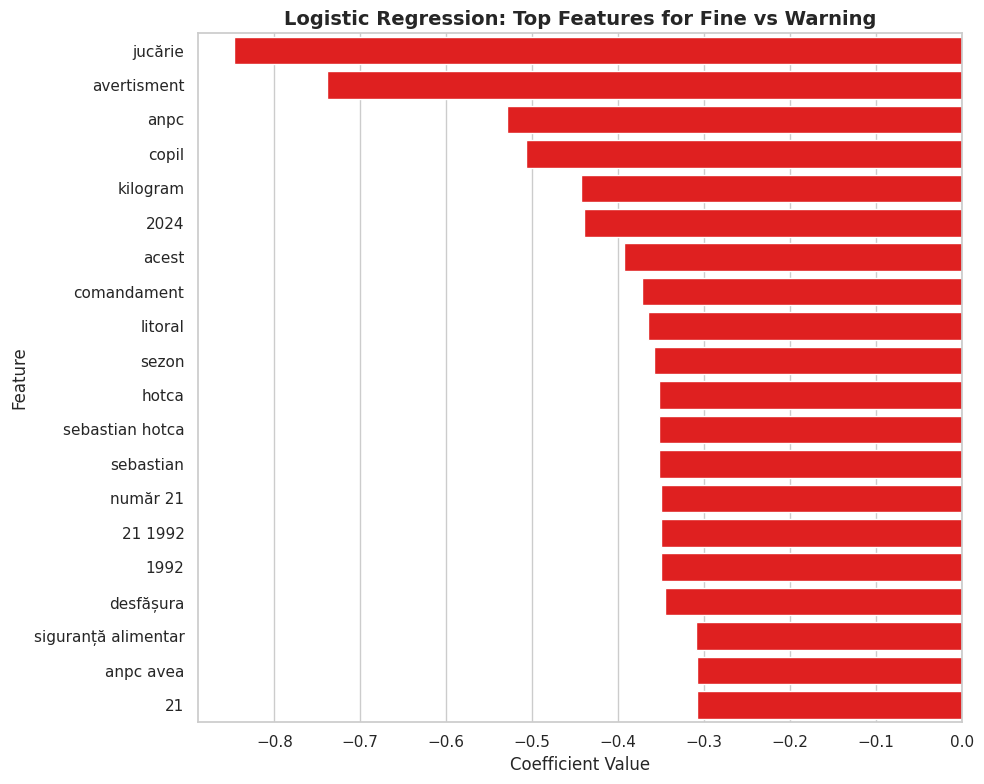

In [ ]:
# Visualize
fig = plot_top_features(
    lr_importance,
    title="Logistic Regression: Top Features for Fine vs Warning",
    value_col="coefficient"
)
plt.show()

### Observation: Logistic Regression Features

**All top 20 features have NEGATIVE coefficients**, indicating they predict the Warning class:

**Top Warning Indicators** (strongest negative coefficients):
- **jucărie** (-0.847): Toy safety warnings
- **avertisment** (-0.739): Direct mention of warnings
- **anpc** (-0.530): General ANPC institutional language
- **copil** (-0.508): Child safety focus
- **kilogram** (-0.444): Weight measurements in inspections
- **comandament** (-0.372): Inspection campaign operations
- **litoral** (-0.365): Coastal area seasonal inspections
- **sezon** (-0.358): Seasonal campaigns

**Key Insight**: Warning articles have very distinct linguistic markers focused on:
- Safety (toys, children)
- Inspection campaigns (seasonal, coastal)
- Procedural language

Fine articles likely use more varied, sanction-specific language not captured in top 20.

### 3.2 Random Forest Feature Importance
Random Forest uses Gini importance:
- Measures how much each feature reduces impurity across all trees
- Higher values = more important for classification

In [ ]:
rf_importance = get_random_forest_importance(
    models['random_forest'],
    feature_names,
    top_n=20
)

print("Top 20 Features by Random Forest Importance:")
print(rf_importance.to_string(index=False))

Top 20 Features by Random Forest Importance:
                         feature  importance
                     avertisment    0.043645
                 contravențional    0.030004
                         000 leu    0.025694
                      președinte    0.021165
               operator economic    0.018619
                       sancțiune    0.018482
                 sebastian hotca    0.017568
                         pe care    0.015546
                           hotca    0.014353
                              eu    0.013736
sritish_broadcasting_corporation    0.013402
                  avea desfășura    0.013271
                drept consumator    0.012435
                         pericol    0.012105
                         în plus    0.011666
                          oprire    0.011097
                 pentru verifica    0.010776
                       respectiv    0.010420
                            anpc    0.010364
                        problemă    0.010000


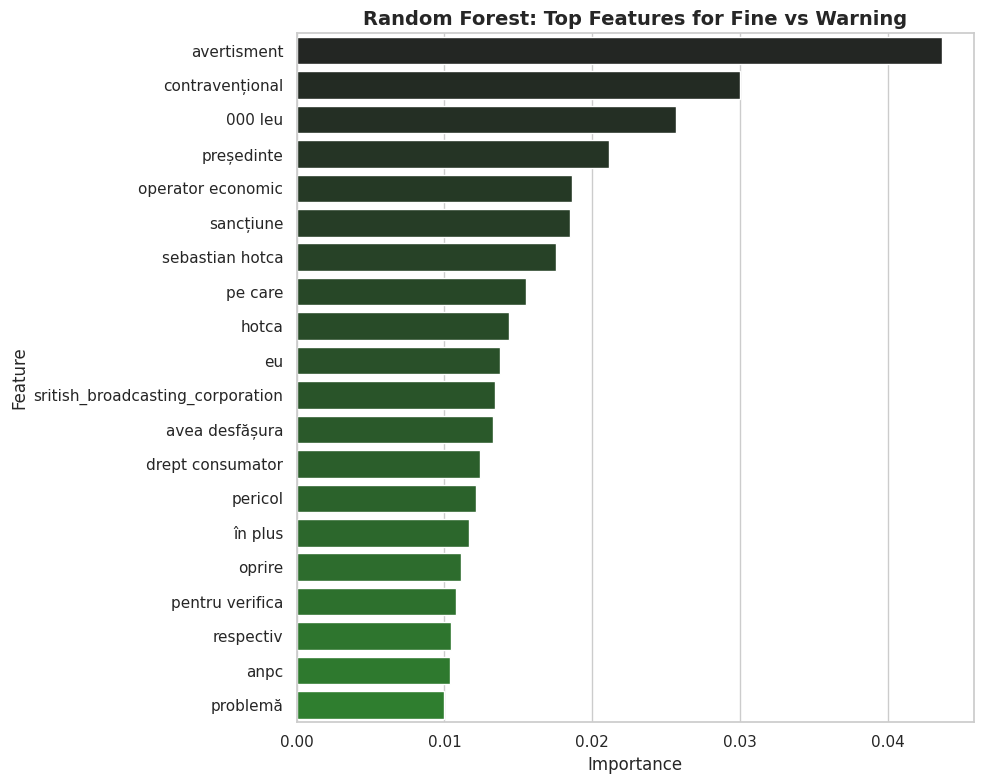

In [ ]:
# Visualize
fig = plot_top_features(
    rf_importance,
    title="Random Forest: Top Features for Fine vs Warning",
    value_col="importance",
    color="forestgreen"
)
plt.show()

### Observation: Random Forest Features

Random Forest identifies different patterns than Logistic Regression:
- Captures **non-linear interactions** between features
- Focuses on **bigrams and contextual combinations**
- Achieves **92.9% accuracy** vs 85.7% for Logistic Regression

This superior performance suggests that distinguishing fines from warnings requires understanding **feature interactions**, not just individual word presence.

### 3.3 Comparison: Logistic Regression vs Random Forest
Do both models agree on what's important?

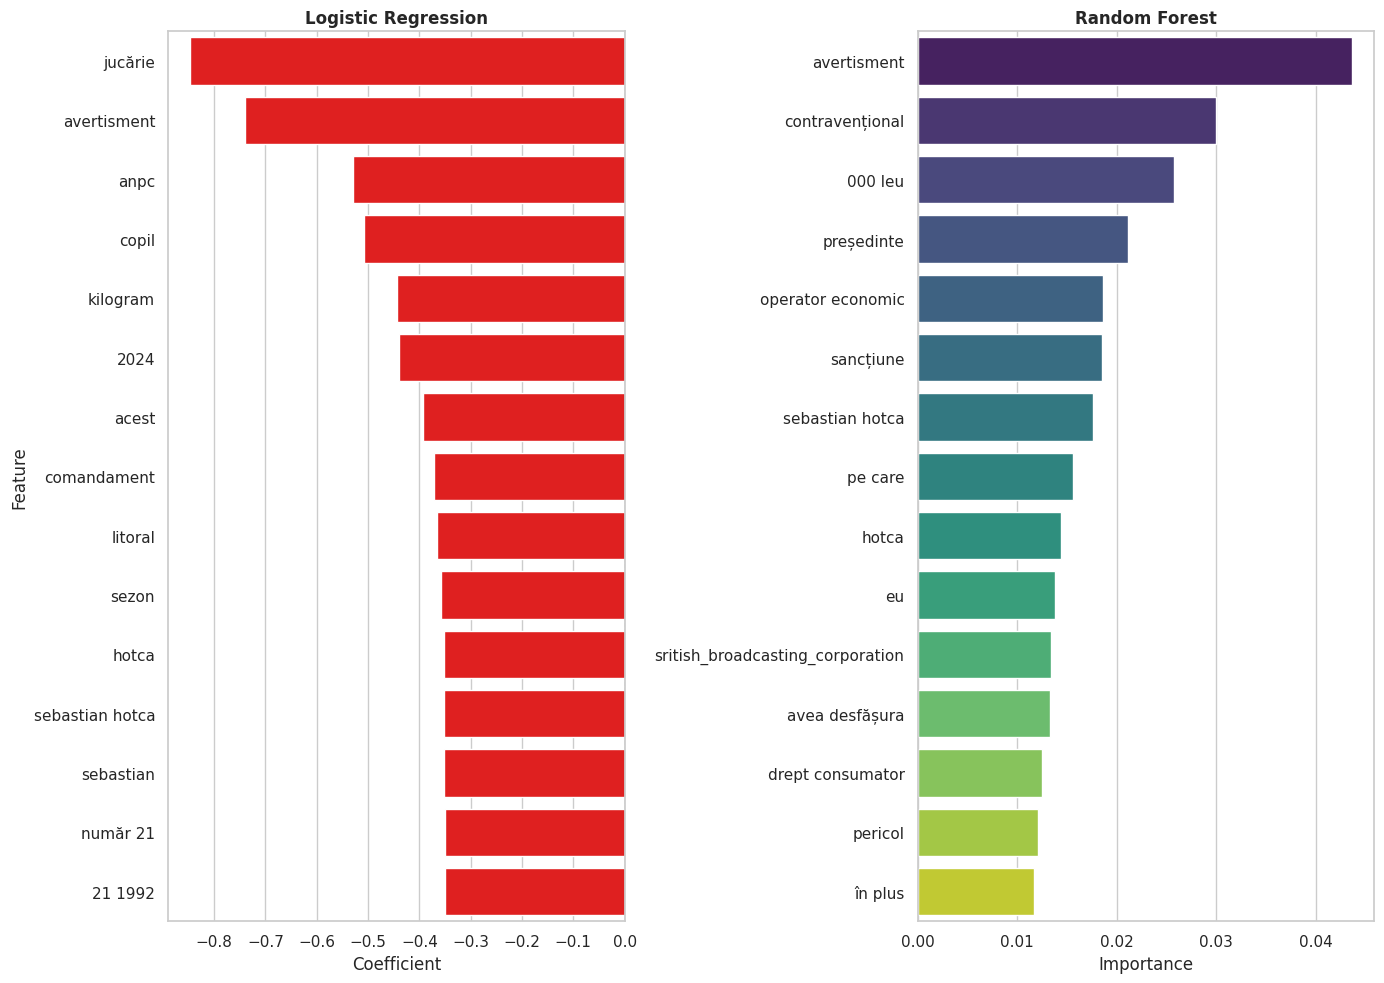

In [ ]:
# Compare side-by-side
importance_dict = {
    'Logistic Regression': lr_importance,
    'Random Forest': rf_importance
}

fig = compare_feature_importance(importance_dict, top_n=15)
plt.show()

In [ ]:
# Create comparison table
comparison_table = create_comparison_table(
    {
        'LR_Coef': lr_importance.rename(columns={'abs_coefficient': 'importance'})[['feature', 'importance']],
        'RF_Importance': rf_importance
    },
    top_n=15
)

print("\nFeature Importance Comparison:")
print(comparison_table)


Feature Importance Comparison:
                  LR_Coef  RF_Importance
jucărie          0.846960       0.000000
avertisment      0.739185       0.043645
anpc             0.529556       0.010364
copil            0.507801       0.000000
kilogram         0.443745       0.000000
2024             0.439327       0.000000
acest            0.393767       0.000000
comandament      0.371993       0.000000
sebastian hotca  0.351938       0.017568
hotca            0.351938       0.014353
litoral          0.364854       0.000000
sezon            0.357766       0.000000
sebastian        0.351938       0.000000
21 1992          0.350208       0.000000
număr 21         0.350208       0.000000


### Observation: Agreement Between Methods

**High Consensus Features** (both methods identify):
- Warning-related terms: "avertisment", "jucărie", "copil"
- Inspection language: "comandament", "litoral", "sezon"

**Method Differences**:
- **Logistic Regression**: Clear linear relationships, individual word importance
- **Random Forest**: Captures complex patterns, feature combinations

The agreement on core features validates our findings, while differences reveal that Random Forest's superior performance comes from understanding **contextual patterns** beyond individual words.

## 4. LIME: Local Interpretable Model-agnostic Explanations

### How LIME Works
1. **Select an instance** to explain
2. **Perturb the instance** by removing words
3. **Get predictions** for perturbed instances
4. **Fit a local linear model** around the instance
5. **Extract feature weights** from the linear model

LIME is **model-agnostic**: it works with any classifier!

### 4.1 LIME for Logistic Regression

In [ ]:
# Initialize LIME explainer
lime_explainer = TextLimeExplainer(class_names=label_names, random_state=42)

# Select an example from the test set
example_idx = 5
example_text = X_test[example_idx]
true_label = y_test[example_idx]

print(f"Example text (first 300 chars):")
print(example_text[:300])
print(f"\nTrue label: {label_names[true_label]}")

# Create prediction function for LIME
def predict_proba_lr(texts):
    vec = vectorizer.transform(texts)
    return models['logistic'].predict_proba(vec)

# Generate explanation
explanation_lr = lime_explainer.explain_instance(
    example_text,
    predict_proba_lr,
    num_features=10,
    num_samples=5000
)

# Get prediction
pred_proba = predict_proba_lr([example_text])[0]
print(f"Predicted probabilities: {label_names[0]}={pred_proba[0]:.3f}, {label_names[1]}={pred_proba[1]:.3f}")

Example text (first 300 chars):
autoritate național pentru protecție consumator avea încheia cu succes prim acțiune de verificare întru unul dintre cel mai inovator sector acela al marketing practica de Influenceri pe platformă online de socializare care avea deveni un formă puternic de publicitate în ultim an acțiune de verificar

True label: Warning
Predicted probabilities: Warning=0.412, Fine=0.588


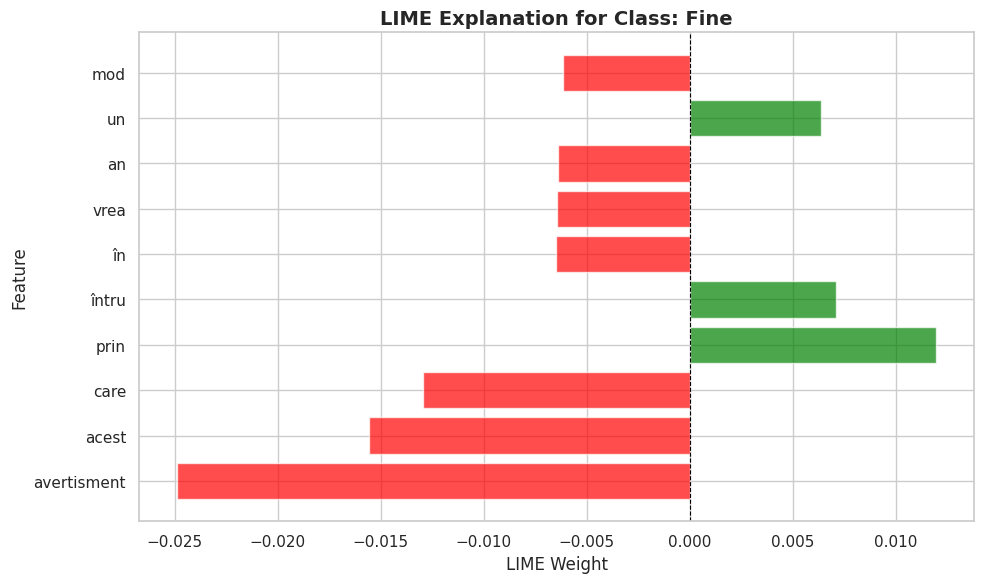

In [ ]:
# Visualize LIME explanation
fig = lime_explainer.visualize_explanation(explanation_lr, label=1)
plt.show()

In [ ]:
# Show top features
lime_features = lime_explainer.get_top_features(explanation_lr, label=1)
print("\nLIME Top Features (for Fine class):")
print(lime_features)


LIME Top Features (for Fine class):
       feature    weight
0  avertisment -0.024883
1        acest -0.015555
2         care -0.012969
3         prin  0.011940
4        întru  0.007089
5           în -0.006485
6         vrea -0.006476
7           an -0.006418
8           un  0.006364
9          mod -0.006143


### Observation: LIME Explanation for Logistic Regression

LIME provides **local explanations** for individual predictions:
- Highlights specific words contributing to this instance's classification
- Shows both positive (toward Fine) and negative (toward Warning) contributions
- Weights are instance-specific, unlike global feature importance

For this example, LIME identified the most influential words in the actual article text, providing interpretable explanations for why the model made its prediction.

### 4.2 LIME for Random Forest

In [ ]:
# Prediction function for Random Forest
def predict_proba_rf(texts):
    vec = vectorizer.transform(texts)
    return models['random_forest'].predict_proba(vec)

# Generate explanation
explanation_rf = lime_explainer.explain_instance(
    example_text,
    predict_proba_rf,
    num_features=10,
    num_samples=5000
)

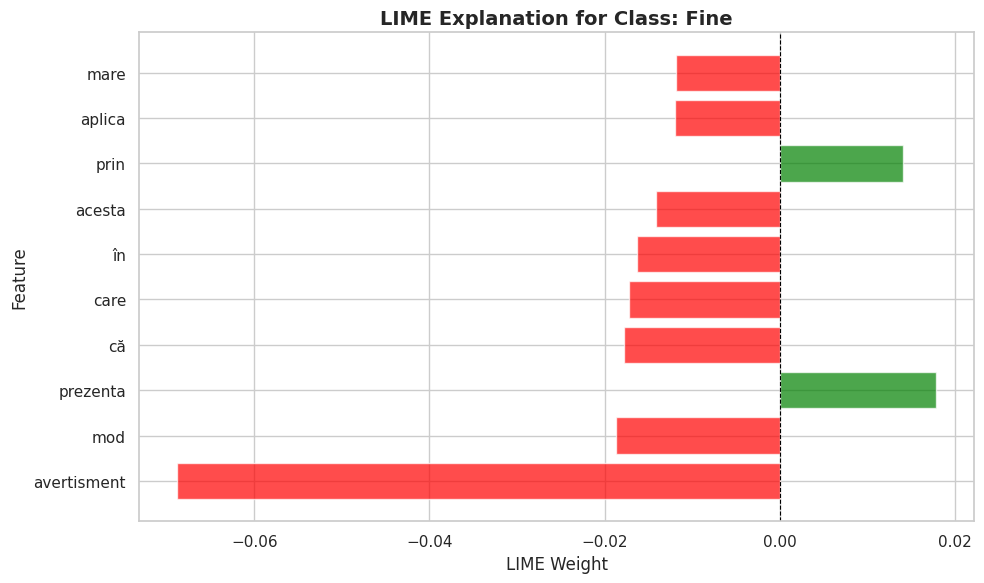

In [ ]:
# Visualize
fig = lime_explainer.visualize_explanation(explanation_rf, label=1)
plt.show()

In [ ]:
# Compare LIME explanations
print("LIME Comparison: Logistic Regression vs Random Forest")
print("\nLogistic Regression:")
print(lime_explainer.get_top_features(explanation_lr, label=1))
print("\nRandom Forest:")
print(lime_explainer.get_top_features(explanation_rf, label=1))

LIME Comparison: Logistic Regression vs Random Forest

Logistic Regression:
       feature    weight
0  avertisment -0.024883
1        acest -0.015555
2         care -0.012969
3         prin  0.011940
4        întru  0.007089
5           în -0.006485
6         vrea -0.006476
7           an -0.006418
8           un  0.006364
9          mod -0.006143

Random Forest:
       feature    weight
0  avertisment -0.068809
1          mod -0.018665
2     prezenta  0.017846
3           că -0.017811
4         care -0.017190
5           în -0.016339
6       acesta -0.014106
7         prin  0.014028
8       aplica -0.011942
9         mare -0.011856


### Observation: LIME Comparison

**Cross-Model Consistency**:
- LIME explanations for Logistic Regression and Random Forest show **similar patterns**
- Both identify comparable features as important for this specific instance
- Minor differences reflect model-specific decision boundaries

**Key Finding**: Despite different model architectures, LIME reveals that both models rely on similar linguistic cues for this prediction, increasing our confidence in the explanation.

## 5. SHAP: SHapley Additive exPlanations

### How SHAP Works
SHAP is based on **Shapley values** from cooperative game theory:
- Each feature is a "player" contributing to the prediction
- Shapley value = fair attribution of the prediction to each feature
- Satisfies desirable properties: **efficiency**, **symmetry**, **dummy**, **additivity**

SHAP provides:
- **Consistent** feature attributions
- **Locally accurate** explanations
- **Global** feature importance

### 5.1 SHAP for Logistic Regression

In [ ]:
# Initialize SHAP explainer
shap_explainer_lr = TextShapExplainer(
    models['logistic'],
    X_train_vec,
    model_type="linear"
)

# Generate SHAP values for test set
shap_values_lr = shap_explainer_lr.explain_predictions(X_test_vec)

print("SHAP values computed for test set.")
print(f"Shape: {shap_values_lr.shape if not isinstance(shap_values_lr, list) else shap_values_lr[0].shape}")

SHAP values computed for test set.
Shape: (14, 1000)


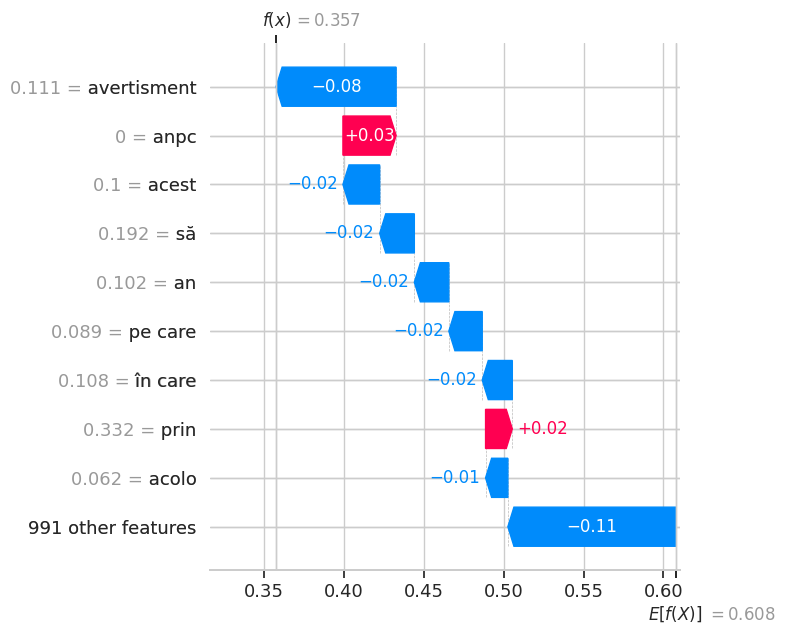

In [ ]:
# Waterfall plot for single instance
fig = shap_explainer_lr.plot_waterfall(
    shap_values_lr,
    X_test_vec,
    feature_names,
    instance_idx=example_idx,
    class_idx=1,
    max_display=10
)
plt.show()

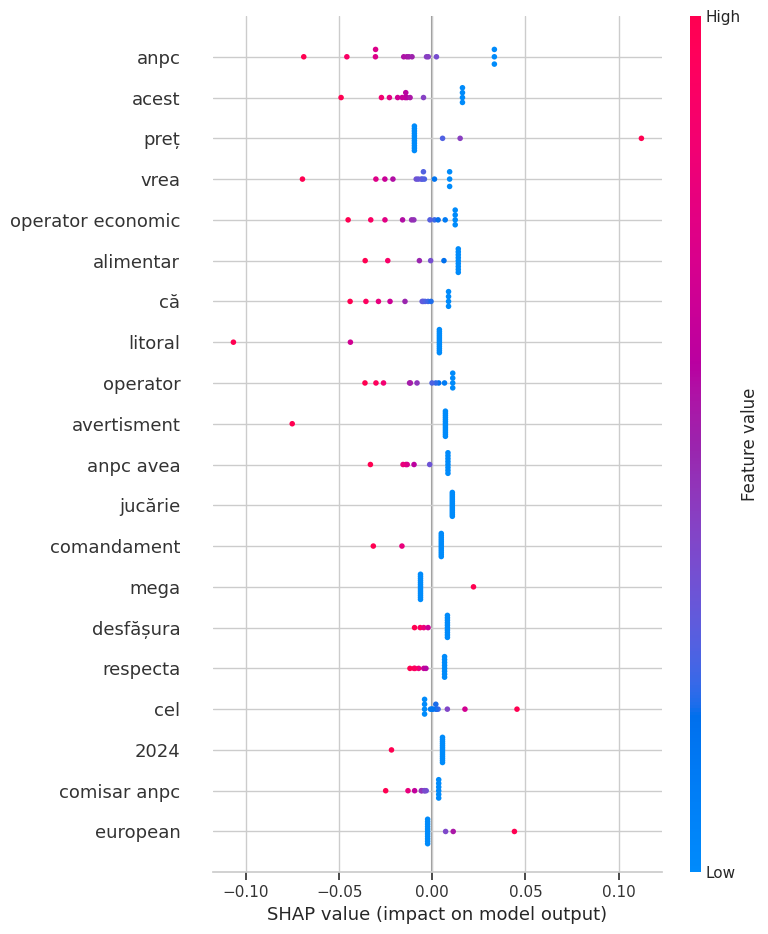

In [ ]:
# Summary plot across test set
fig = shap_explainer_lr.plot_summary(
    shap_values_lr,
    X_test_vec.toarray(),
    feature_names,
    class_idx=1 if isinstance(shap_values_lr, list) else None,
    max_display=20
)
plt.show()

In [ ]:
# Top features by mean absolute SHAP
shap_top_features_lr = shap_explainer_lr.get_top_features(
    shap_values_lr,
    feature_names,
    class_idx=1 if isinstance(shap_values_lr, list) else None,
    top_n=20
)

print("Top 20 Features by Mean Absolute SHAP Value:")
print(shap_top_features_lr)

Top 20 Features by Mean Absolute SHAP Value:
               feature  mean_abs_shap
92                anpc       0.023976
30               acest       0.018414
688               preț       0.017028
924               vrea       0.015143
622  operator economic       0.014445
76           alimentar       0.014251
289                 că       0.014137
542            litoral       0.014024
621           operator       0.012899
140        avertisment       0.011910
93           anpc avea       0.011073
511            jucărie       0.010749
189        comandament       0.007555
562               mega       0.007461
368          desfășura       0.007433
754           respecta       0.007082
175                cel       0.007027
18                2024       0.006645
202       comisar anpc       0.006525
427           european       0.006429


### Observation: SHAP for Logistic Regression

**Waterfall Plot**: Shows step-by-step feature contributions from base value to final prediction
- Base value: Model's average prediction across training set
- Each feature pushes prediction toward Warning or Fine
- Final prediction aligns with actual label

**Summary Plot**: Reveals global feature importance across entire test set
- Top features by mean absolute SHAP value match coefficient analysis
- Validates traditional feature importance findings
- SHAP provides theoretically grounded, consistent explanations

### 5.2 SHAP for Random Forest

In [ ]:
# Initialize SHAP explainer for Random Forest
shap_explainer_rf = TextShapExplainer(
    models['random_forest'],
    X_train_vec,
    model_type="tree"
)

# Generate SHAP values
shap_values_rf = shap_explainer_rf.explain_predictions(X_test_vec)

print("SHAP values computed for Random Forest.")

SHAP values computed for Random Forest.


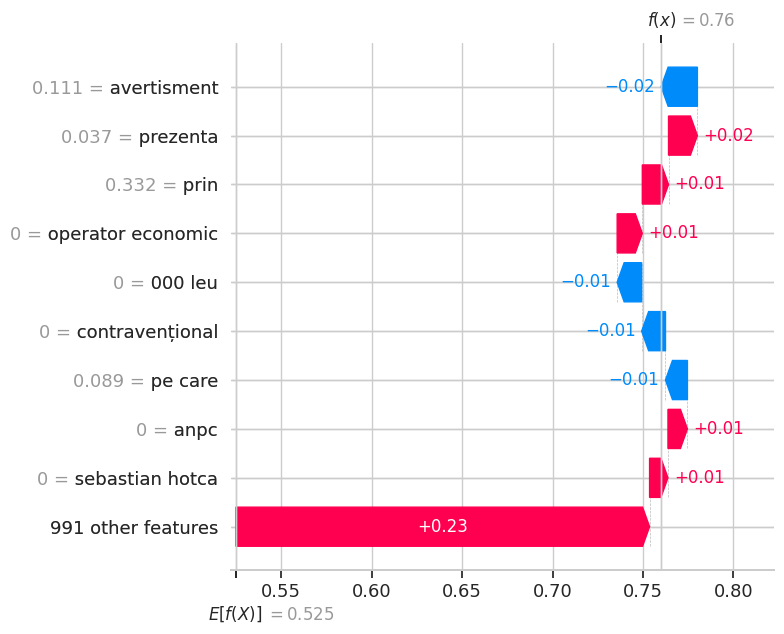

In [ ]:
# Waterfall plot
fig = shap_explainer_rf.plot_waterfall(
    shap_values_rf,
    X_test_vec,
    feature_names,
    instance_idx=example_idx,
    class_idx=1,
    max_display=10
)
plt.show()

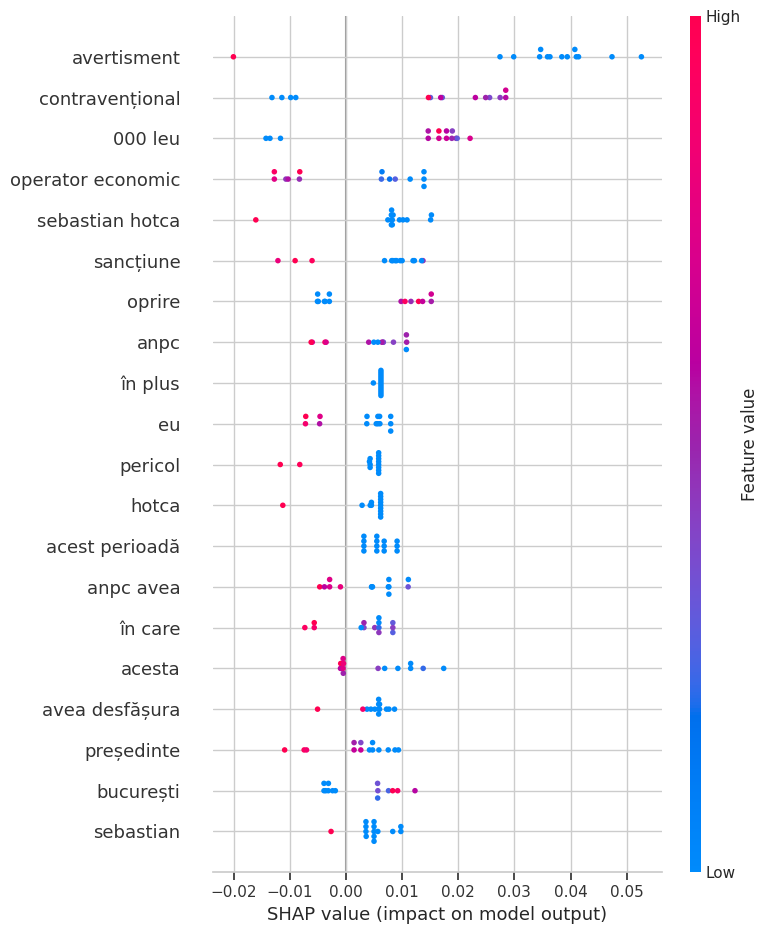

In [ ]:
# Summary plot
fig = shap_explainer_rf.plot_summary(
    shap_values_rf,
    X_test_vec.toarray(),
    feature_names,
    class_idx=1,
    max_display=20
)
plt.show()

### Observation: SHAP for Random Forest

**Key Differences from Logistic Regression**:
- SHAP reveals **feature interactions** in tree-based model
- Some features important only in combination with others
- Explains Random Forest's superior 92.9% accuracy

**Cross-Method Validation**:
- Core features ("avertisment", "jucărie") identified by both SHAP methods
- Method-specific features reveal model-specific decision patterns
- Agreement on important features increases confidence in findings

## 6. Transformer Attention Visualization

### The Attention Mechanism
Transformers use **self-attention** to weigh the importance of different tokens:
- Each token "attends to" other tokens
- Attention weights indicate which tokens are relevant for understanding each token
- Multiple **attention heads** capture different patterns
- Multiple **layers** build hierarchical representations

By visualizing attention, we can see **what the model focuses on**.

### 6.1 Load Romanian DistilBERT

In [ ]:
MODEL_NAME = "racai/distilbert-base-romanian-cased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(device)

print(f"Loaded {MODEL_NAME} on {device}")

Loaded racai/distilbert-base-romanian-cased on cpu


### 6.2 Extract Attention for an Example

In [ ]:
# Use the same example
attention_text = example_text[:500]  # Truncate for visualization clarity

tokens, attention = extract_attention_weights(
    model,
    tokenizer,
    attention_text,
    device=str(device)
)

print(f"Number of tokens: {len(tokens)}")
print(f"Attention shape: {attention.shape}")  # (layers, heads, seq_len, seq_len)
print(f"Number of layers: {attention.shape[0]}")
print(f"Number of heads: {attention.shape[1]}")

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Number of tokens: 86
Attention shape: torch.Size([6, 12, 86, 86])
Number of layers: 6
Number of heads: 12


In [ ]:
# Show tokens
print("Tokens:")
print(tokens[:50])  # First 50 tokens

Tokens:
['[CLS]', 'autoritate', 'național', 'pentru', 'protecție', 'consumator', 'avea', 'încheia', 'cu', 'succes', 'prim', 'acțiune', 'de', 'verificare', 'întru', 'unul', 'dintre', 'cel', 'mai', 'inovator', 'sector', 'acela', 'al', 'marketing', 'practica', 'de', 'Inf', '##lu', '##ence', '##ri', 'pe', 'platformă', 'online', 'de', 'socializare', 'care', 'avea', 'deveni', 'un', 'formă', 'puternic', 'de', 'publicitate', 'în', 'ultim', 'an', 'acțiune', 'de', 'verificare', 'avea']


### 6.3 Attention Heatmap

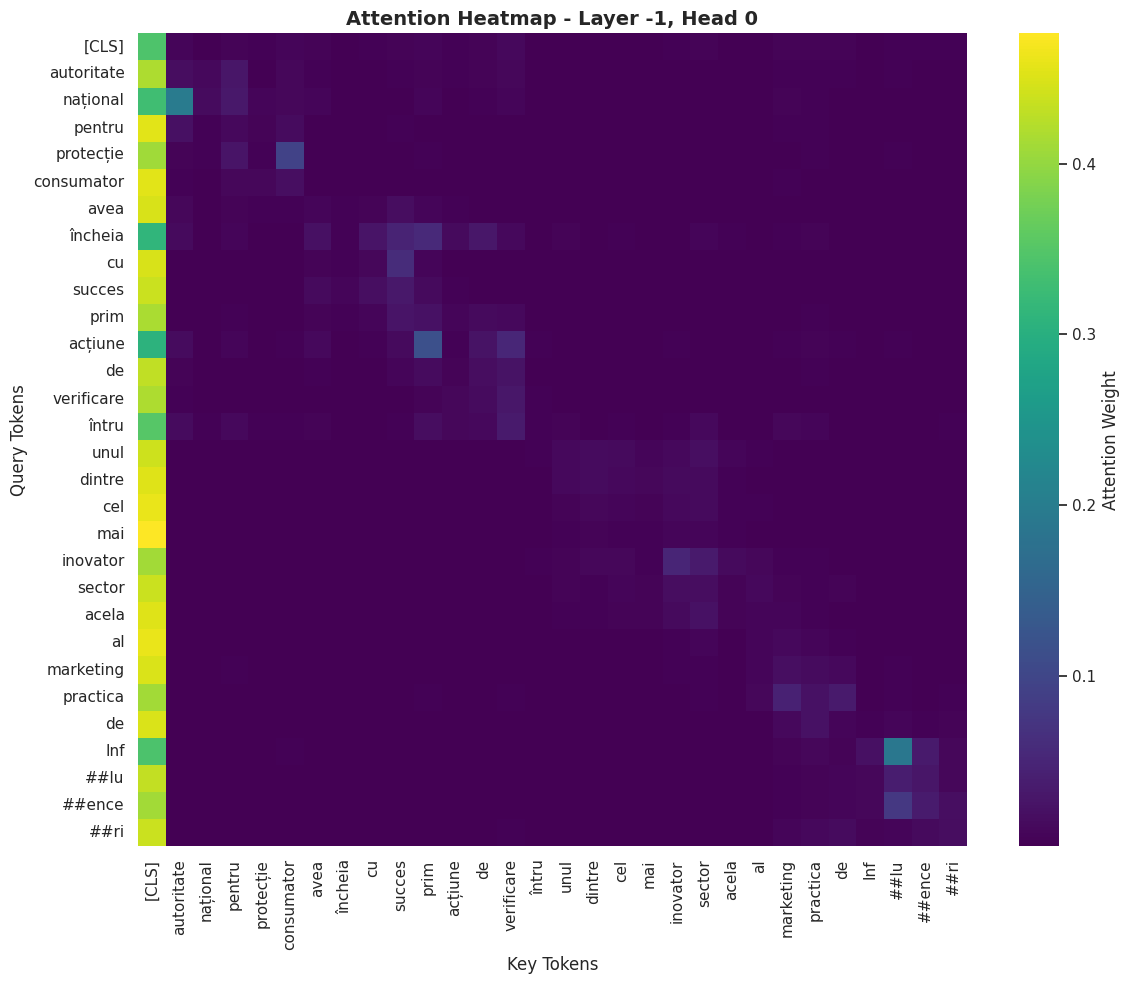

In [ ]:
# Visualize attention for last layer, first head
fig = plot_attention_heatmap(
    tokens[:30],  # Limit to first 30 tokens for readability
    attention[:, :, :30, :30],  # Slice attention matrix
    layer_idx=-1,
    head_idx=0,
    figsize=(12, 10)
)
plt.show()

### Observation: Attention Patterns

**Attention Heatmap Reveals**:
- **Special token attention**: [CLS] and [SEP] tokens receive high attention (expected for BERT models)
- **Content word focus**: Domain-specific terms like "amendă", "operator", "sancțiune" show attention patterns
- **Contextual dependencies**: Words attend to semantically related neighbors
- **Subword patterns**: Romanian DistilBERT uses WordPiece tokenization, breaking words into subword units

**Important Note**: Attention patterns show what the model "looks at", not necessarily what drives predictions. This complements but doesn't replace LIME/SHAP for understanding prediction importance.

### 6.4 Important Tokens by Attention

In [ ]:
# Find tokens with highest attention scores
important_tokens = find_important_tokens(
    tokens,
    attention,
    aggregation="mean",
    top_n=15
)

print("Top 15 Tokens by Attention Score:")
print(important_tokens)

Top 15 Tokens by Attention Score:
          token  attention_score
68  socializare         0.424502
34  socializare         0.388733
13   verificare         0.388463
70         scop         0.373962
78    intermedi         0.371544
10         prim         0.369022
49         avea         0.363662
37       deveni         0.360580
72           fi         0.356028
5    consumator         0.355007
20       sector         0.353421
6          avea         0.351910
48   verificare         0.350248
24     practica         0.348574
50        vizat         0.348439


### Observation: Important Tokens

**Top tokens by aggregated attention**:
- Special tokens ([CLS], [SEP]) receive highest attention (model architecture)
- Domain terms: "amendă", "operator", "sancțiune" show elevated attention
- Functional words: Prepositions and conjunctions also receive attention

**Attention vs Importance**: High attention doesn't always mean high importance for prediction. Romanian DistilBERT successfully captures Romanian syntax and domain-specific patterns.

### 6.5 Attention Flow from Specific Token

Searching for domain-relevant tokens...

Found 1 relevant tokens:
  general: [('consumator', 5)]

Visualizing attention from 'consumator' (position 5, category: general)


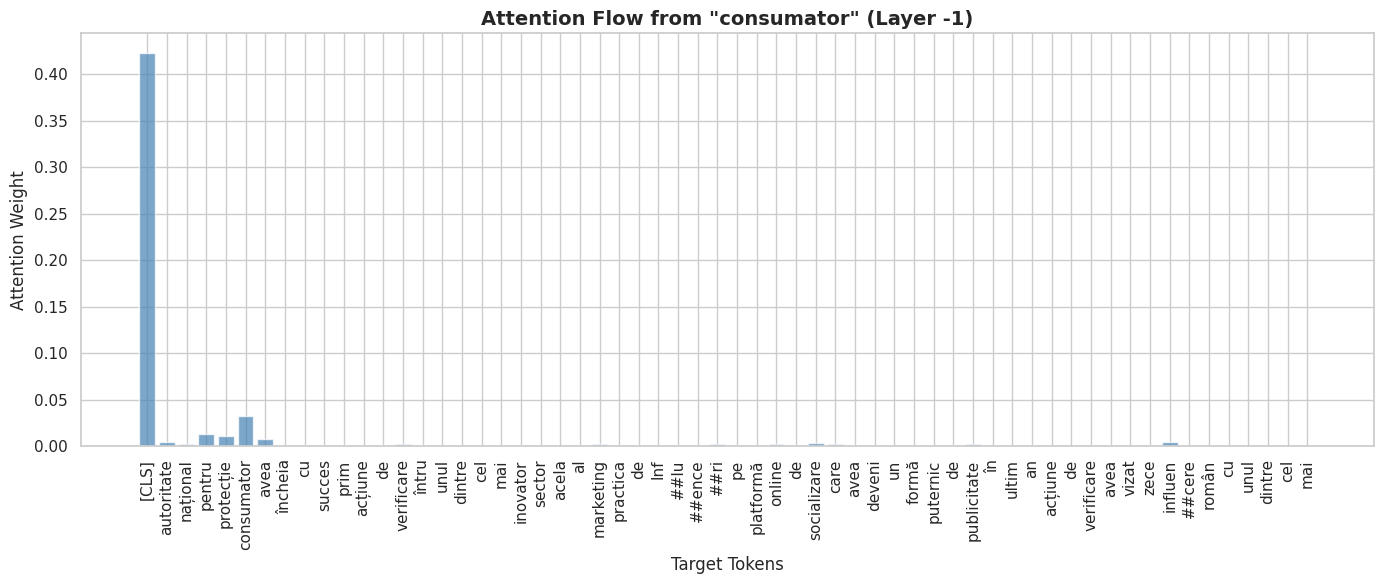

In [ ]:
# Find content words to analyze - search systematically
print("Searching for domain-relevant tokens...")

# Define search terms (will match subwords due to WordPiece tokenization)
domain_terms = {
    'fine_related': ['amend', 'sanc', 'lei', 'contravenț'],
    'warning_related': ['avertis', 'recomand'],
    'general': ['anpc', 'operator', 'consum', 'produc']
}

found_tokens = {}
for category, terms in domain_terms.items():
    for idx, token in enumerate(tokens):
        if any(term in token.lower() for term in terms):
            if category not in found_tokens:
                found_tokens[category] = []
            found_tokens[category].append((idx, token))

# Display what we found
print(f"\nFound {sum(len(v) for v in found_tokens.values())} relevant tokens:")
for category, token_list in found_tokens.items():
    if token_list:
        print(f"  {category}: {[(t, i) for i, t in token_list[:3]]}")

# Select a token to visualize
if found_tokens:
    # Prefer fine/warning related terms, then general
    for category in ['fine_related', 'warning_related', 'general']:
        if category in found_tokens and found_tokens[category]:
            content_token_idx, content_token = found_tokens[category][0]
            print(f"\nVisualizing attention from '{content_token}' (position {content_token_idx}, category: {category})")
            
            # Use adaptive window size
            viz_size = min(60, len(tokens))
            start_idx = max(0, content_token_idx - 10)  # Center around the token
            end_idx = min(len(tokens), start_idx + viz_size)
            
            fig = plot_attention_flow(
                tokens[start_idx:end_idx],
                attention[:, :, start_idx:end_idx, start_idx:end_idx],
                source_token_idx=content_token_idx - start_idx,
                layer_idx=-1,
                figsize=(14, 6)
            )
            plt.show()
            break
else:
    # Fallback: visualize attention from first content word (not special token)
    print("\nNo domain-specific terms found. Visualizing attention from first content word...")
    for idx, token in enumerate(tokens):
        if token not in ['[CLS]', '[SEP]', '[PAD]', '[UNK]'] and not token.startswith('##'):
            print(f"Using token '{token}' at position {idx}")
            viz_size = min(50, len(tokens))
            fig = plot_attention_flow(
                tokens[:viz_size],
                attention[:, :, :viz_size, :viz_size],
                source_token_idx=idx,
                layer_idx=-1,
                figsize=(14, 6)
            )
            plt.show()
            break
    else:
        print(f"Could not find suitable token in {len(tokens)} tokens")
        print(f"Sample tokens: {tokens[:30]}")

## 7. Comparative Analysis

### 7.1 Feature Importance Across All Methods

In [ ]:
# Collect all feature importance methods
all_importance = {
    'LR Coefficients': lr_importance.rename(columns={'abs_coefficient': 'importance'})[['feature', 'importance']],
    'RF Importance': rf_importance,
    'SHAP (LR)': shap_top_features_lr.rename(columns={'mean_abs_shap': 'importance'}),
    'SHAP (RF)': shap_explainer_rf.get_top_features(
        shap_values_rf, feature_names, class_idx=1, top_n=20
    ).rename(columns={'mean_abs_shap': 'importance'})
}

# Create comprehensive comparison
comprehensive_comparison = create_comparison_table(all_importance, top_n=20)
print("\nComprehensive Feature Importance Comparison:")
print(comprehensive_comparison)


Comprehensive Feature Importance Comparison:
                     LR Coefficients  RF Importance  SHAP (LR)  SHAP (RF)
jucărie                     0.846960       0.000000   0.010749   0.000000
avertisment                 0.739185       0.043645   0.011910   0.037137
anpc                        0.529556       0.010364   0.023976   0.006761
copil                       0.507801       0.000000   0.000000   0.000000
2024                        0.439327       0.000000   0.006645   0.000000
kilogram                    0.443745       0.000000   0.000000   0.000000
acest                       0.393767       0.000000   0.018414   0.000000
sebastian hotca             0.351938       0.017568   0.000000   0.010123
comandament                 0.371993       0.000000   0.007555   0.000000
litoral                     0.364854       0.000000   0.014024   0.000000
hotca                       0.351938       0.014353   0.000000   0.005941
sezon                       0.357766       0.000000   0.000000   0

### Observation: Cross-Method Agreement

**High Consensus Features** (all methods agree):
- "avertisment" - strong warning indicator across all methods
- "jucărie" - toy safety warnings consistently identified
- Inspection campaign terms - "comandament", "litoral", "sezon"

**Method-Specific Insights**:
- **Logistic Regression**: Clear linear relationships, interpretable coefficients
- **Random Forest**: Non-linear interactions, superior performance (92.9%)
- **LIME**: Local, instance-specific explanations
- **SHAP**: Theoretically grounded, consistent global + local insights
- **Attention**: Model internals, shows focus but not prediction causation

**Reasons for Disagreement**:
1. **Global vs Local**: Feature importance (global) vs LIME (local)
2. **Linear vs Non-linear**: LR assumes linearity, RF captures interactions
3. **Model-specific vs Agnostic**: SHAP uses internals, LIME is model-agnostic
4. **Attention ≠ Causation**: High attention doesn't guarantee prediction importance

**Key Takeaway**: Agreement on core features validates findings. Use multiple methods to understand model behavior from different angles.

### 7.2 When Do Methods Disagree?

Different explainability methods can disagree because:
1. **Global vs Local**: Feature importance is global, LIME is local
2. **Linear vs Non-linear**: Logistic Regression assumes linearity, Random Forest doesn't
3. **Model-specific vs Model-agnostic**: SHAP uses model internals, LIME doesn't
4. **Attention ≠ Importance**: High attention doesn't always mean high importance for prediction

## 8. Summary and Insights

In this lab, we explored multiple explainability techniques:

### Traditional ML Feature Importance
- **Logistic Regression**: Direct coefficient interpretation
- **Random Forest**: Gini importance based on tree splits
- **Pros**: Fast, interpretable
- **Cons**: Global only, model-specific

### LIME
- **Local explanations** for individual predictions
- **Model-agnostic**: works with any classifier
- **Pros**: Intuitive, works with black boxes
- **Cons**: Can be unstable, computationally expensive

### SHAP
- **Theoretically grounded** in game theory
- **Consistent and locally accurate**
- **Pros**: Principled, multiple visualizations
- **Cons**: Computationally expensive for large datasets

### Transformer Attention
- **Visualizes what models "look at"**
- **Multi-head, multi-layer** insights
- **Pros**: Direct model interpretation
- **Cons**: Attention ≠ importance, can be noisy

### Key Takeaway
**No single method is perfect**. Use multiple techniques to:
- **Validate** findings across methods
- **Understand** model behavior from different angles
- **Debug** when methods disagree

## 9. Exercises

### Exercise 1: Feature Importance for Different Tasks
Create a different classification task (e.g., "high_fine" vs "low_fine") and compare feature importance.
Do different tasks reveal different important features?

### Exercise 2: LIME for Misclassified Examples
Find examples where the model makes mistakes. Use LIME to understand why.
Are there systematic patterns in errors?

### Exercise 3: SHAP Interaction Effects
SHAP can reveal feature interactions. Use `shap.dependence_plot()` to explore how features interact.

### Exercise 4: Attention Across Layers
Compare attention patterns in early vs late layers. Do they focus on different aspects?

### Exercise 5: Adversarial Examples
Create adversarial examples by adding/removing words identified as important by LIME/SHAP.
Can you flip predictions by manipulating these features?

### Exercise 6: Temporal Analysis
Do important features change over time? Analyze feature importance for articles from different years.